In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from src.data import get_data
from src.util import common

from src.features.build_features import series_to_supervised

import pickle

In [2]:
df = df = pd.read_csv('../data/raw/data.csv', index_col=0)
df = df[['timestamp','open','high','close','low','volumeto', 'volumefrom']]

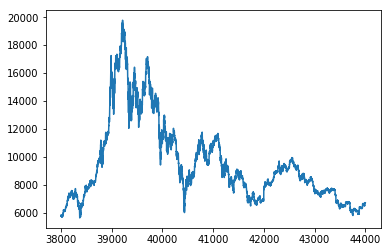

In [3]:
TRAIN_DATA_START_HOUR_INDEX = 38000
df=df.iloc[TRAIN_DATA_START_HOUR_INDEX:,:]
plt.plot(df.close)

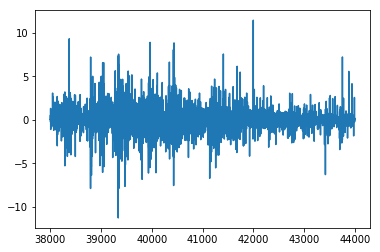

In [5]:
df['percent_change']=df.close.pct_change()*100
df.head()
plt.plot(df.percent_change)

In [7]:
MAS = [6, 12,24,48,72]
for MA in MAS:
    df['vt_ma' + str(MA)] = df.volumeto.rolling(MA).mean()
    df['vf_ma' + str(MA)] = df.volumefrom.rolling(MA).mean()
# df.drop(['volumefrom', 'volumeto'], axis=1, inplace=True)
df.head()

,timestamp,open,high,close,low,volumeto,volumefrom,percent_change,vt_ma6,vf_ma6,vt_ma12,vf_ma12,vt_ma24,vf_ma24,vt_ma48,vf_ma48,vt_ma72,vf_ma72
38000,2017-10-27 21:00:00,5720.81,5771.76,5746.76,5718.96,16627196.53,2890.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38001,2017-10-27 22:00:00,5746.75,5750.77,5748.69,5708.47,13858838.31,2414.91,0.033584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38002,2017-10-27 23:00:00,5748.58,5788.10,5747.98,5744.09,14572098.03,2523.99,-0.012351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38003,2017-10-28 00:00:00,5747.85,5779.01,5779.01,5736.39,13103265.76,2273.05,0.539842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38004,2017-10-28 01:00:00,5778.62,5783.08,5764.56,5737.18,7501329.72,1301.45,-0.250043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


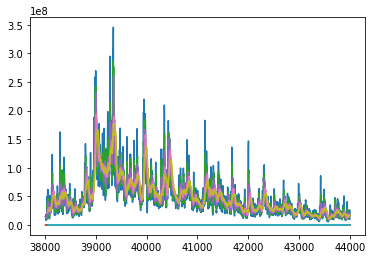

In [8]:
plt.plot(df.filter(regex='v(t|f)'))

In [9]:
df = df.drop(['timestamp'], axis=1)\
    .dropna(how='any', axis=0)

df.head()

,open,high,close,low,volumeto,volumefrom,percent_change,vt_ma6,vf_ma6,vt_ma12,vf_ma12,vt_ma24,vf_ma24,vt_ma48,vf_ma48,vt_ma72,vf_ma72
38071,6108.27,6142.07,6114.50,6106.54,19018707.65,3104.20,0.303642,2.807578e+07,4608.351667,2.399177e+07,3917.979167,3.135467e+07,5100.849167,2.972925e+07,4971.270833,2.432889e+07,4099.363056
38072,6114.47,6116.22,6079.13,6070.78,18808365.29,3084.87,-0.578461,2.769167e+07,4551.751667,2.402040e+07,3924.664167,2.939191e+07,4775.754583,2.980223e+07,4980.240417,2.435918e+07,4102.058333
38073,6079.13,6110.43,6103.63,6076.51,11401782.46,1868.41,0.403018,2.047373e+07,3364.600000,2.399747e+07,3921.816667,2.352689e+07,3833.305833,2.979754e+07,4977.035417,2.432506e+07,4094.468056
38074,6103.70,6121.17,6088.75,6087.09,10348250.97,1692.11,-0.243789,1.596452e+07,2617.851667,2.338123e+07,3822.994167,2.168417e+07,3536.024167,2.984039e+07,4982.128333,2.426639e+07,4082.914167
38075,6088.75,6111.22,6100.40,6086.79,11048160.38,1808.24,0.191336,1.470214e+07,2408.268333,2.201566e+07,3605.112500,2.057921e+07,3357.438750,2.995636e+07,4999.937083,2.423785e+07,4076.458472


In [10]:
N_FEATURES = len(df.columns)
Tx = 72
Ty = 1
N_FEATURES

17

In [11]:
X = series_to_supervised(data=df, n_in=Tx, n_out=Ty)
Y = series_to_supervised(data=list(df['percent_change']), n_in=Tx, n_out=Ty)

In [12]:
"""
Train dev split. (80/20) rule is kind of over. Taking the dev set from the end of the data set because 
that data is closest in distribution to our current testing scenario (getting real time predictions). Note: I call
the dev set the 'test' set in the variable names, but it's really a dev set.
"""
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, shuffle=False)
"""
Now trim the feature values from the outcome matrix and the outcome values from the feature matrix
"""
Y_train = Y_train.iloc[:,-Ty:]
Y_test = Y_test.iloc[:,-Ty:]
X_train = X_train.iloc[:,:-(Ty*N_FEATURES)]
X_test = X_test.iloc[:,:-(Ty*N_FEATURES)]


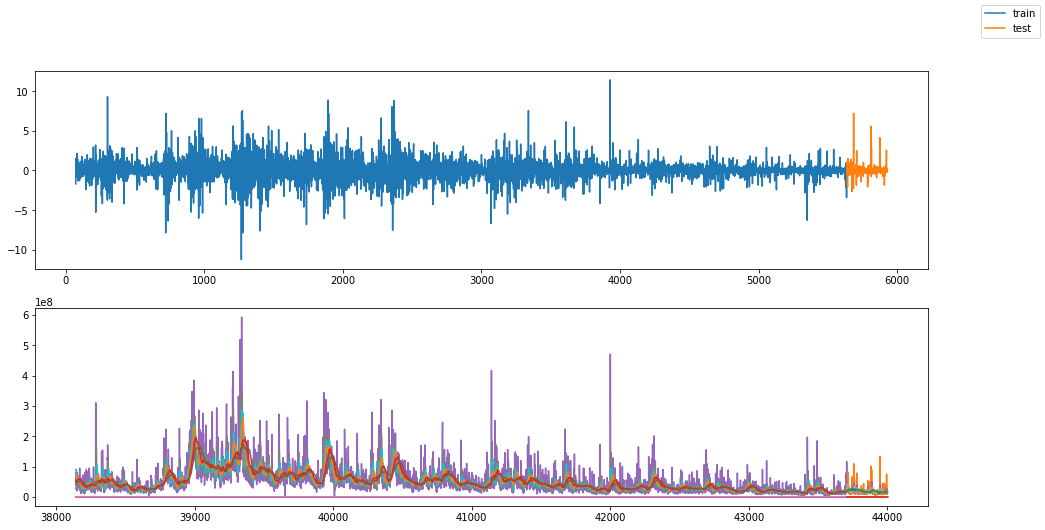

In [13]:
fig, ax = plt.subplots(2)
fig.set_size_inches(16,8)
ax[0].plot(Y_train, label='train')
ax[0].plot(Y_test, label='test')

ax[1].plot(X_train.iloc[:,-N_FEATURES:])
ax[1].plot(X_test.iloc[:,-N_FEATURES:])
fig.legend()

In [14]:
X_train.to_csv('../data/processed/X_train_tx{}_ty{}.csv'.format(Tx, Ty),index=False)
X_test.to_csv('../data/processed/X_test_tx{}_ty{}.csv'.format(Tx, Ty),index=False)
Y_train.to_csv('../data/processed/Y_train_tx{}_ty{}.csv'.format(Tx, Ty),index=False)
Y_test.to_csv('../data/processed/Y_test_tx{}_ty{}.csv'.format(Tx, Ty),index=False)